# 0. Import Library & Set DIR

In [86]:
import json
import matplotlib.pyplot as plt
from datetime import datetime

In [87]:
log_dir = 'logs/DINO/train_10000_5000_4scale_rs50_12epc/'

# 1. Effectiveness

### 1-1) Loss in entire epoch

In [88]:
with open(log_dir + 'loss_only.txt', 'r') as f:
    ent_loss_res = f.readlines()

In [89]:
cnt = 1
ent_loss_dict = {}
tmp = []

for loss in ent_loss_res:
    tmp.append(
        float(loss.split(':')[1].strip())
    )
    if '9990 :' in loss:
        ent_loss_dict[f'{cnt}_epoch'] = tmp
        cnt += 1
        tmp = []

- For all epoch

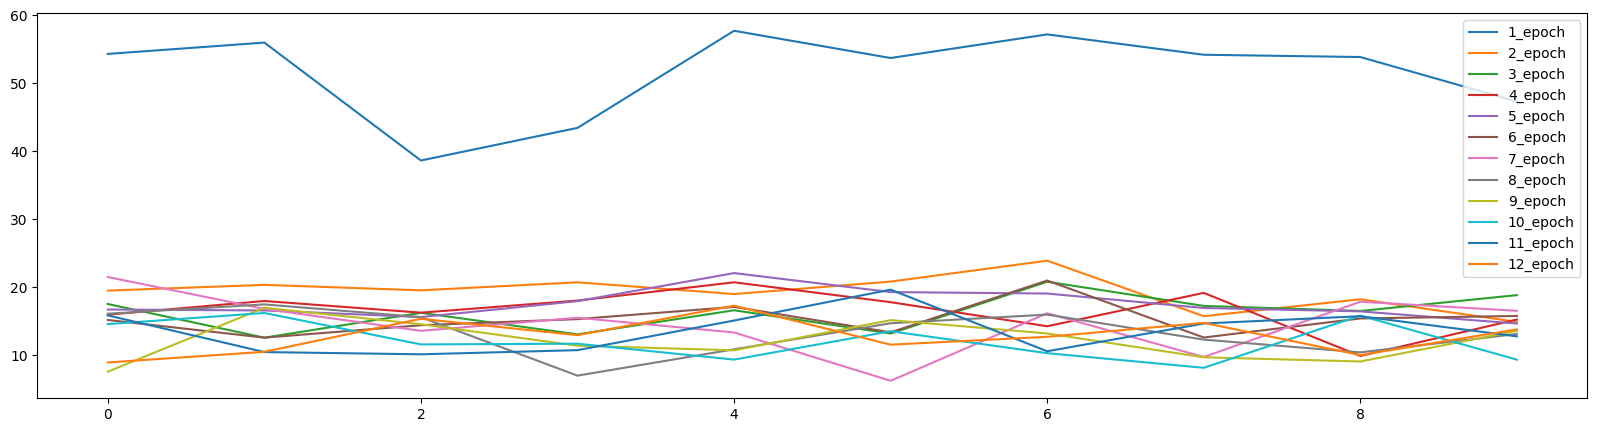

In [90]:
plt.figure(figsize=(20,5))
for epoch in ent_loss_dict:
    plt.plot(ent_loss_dict[epoch][:10], label=epoch)
plt.legend()

- Only 1, 6, 12 epoch

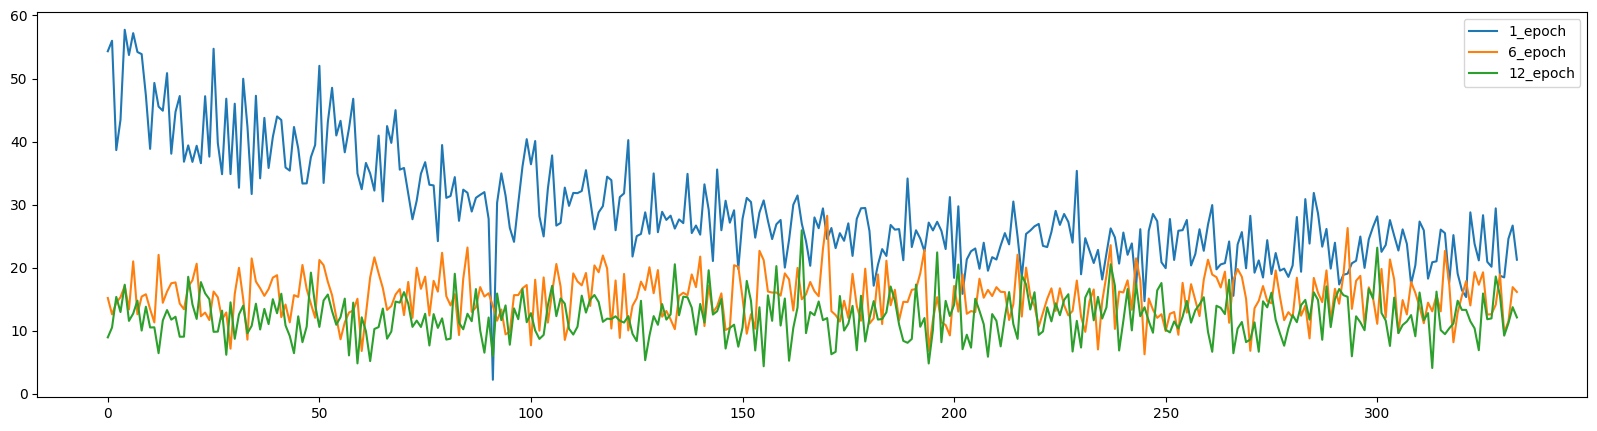

In [92]:
plt.figure(figsize=(20,5))
plt.plot(ent_loss_dict['1_epoch'], label='1_epoch')
plt.plot(ent_loss_dict['6_epoch'], label='6_epoch')
plt.plot(ent_loss_dict['12_epoch'], label='12_epoch')
plt.legend()

### 1-2) Loss (mean of epoch)

In [167]:
with open(log_dir + 'log.txt', 'r') as f:
    mean_loss_res = f.readlines()

In [168]:
cnt = 1
mean_loss_dict = {}

for loss in mean_loss_res:
    mean_loss_dict[f'{cnt}_epoch'] = json.loads(loss)
    cnt += 1

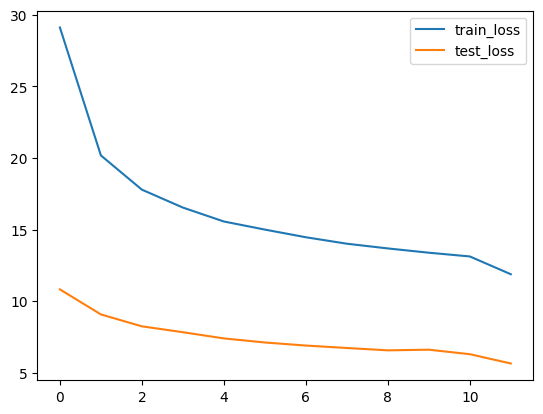

In [169]:
loss_keywords = ['train_loss', 'test_loss']

for keyword in loss_keywords:
    plt.plot(
        [mean_loss_dict[epoch][keyword] for epoch in mean_loss_dict],
        label = keyword
    )

plt.legend()

### 1-3) AP

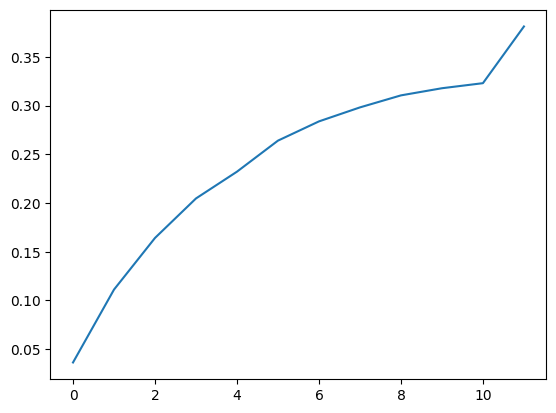

In [150]:
plt.plot(
    [mean_loss_dict[epoch]['best_res'] for epoch in mean_loss_dict],
    label = 'best_res'
)

### 1-4) Epoch Time

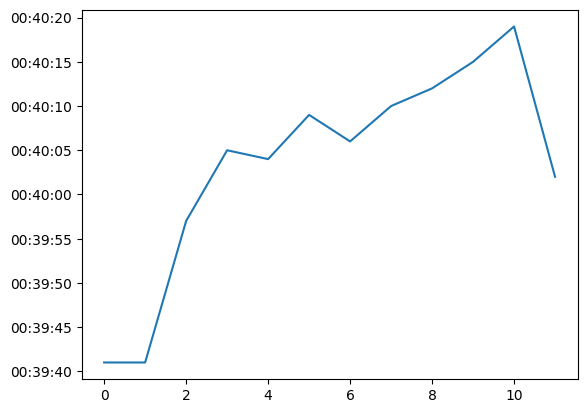

In [165]:
plt.plot(
    [
        datetime.strptime(
            mean_loss_dict[epoch]['epoch_time'],
            '%H:%M:%S'
        )
        for epoch in mean_loss_dict
    ],
    label = 'epoch_time'
)

# 2. Performance

### 2-1) Settings

In [180]:
import torch
import datasets.transforms as T

from main import build_model_main
from util.visualizer import COCOVisualizer
from util.slconfig import SLConfig
from PIL import Image
from util import box_ops
import numpy as np
import warnings

warnings.filterwarnings(action='ignore')

In [184]:
str(12)

'12'

In [216]:
# import coco id&name mapping json
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# set params
model_config_path = "config/DINO/DINO_4scale.py"
img_dir = "figs/test.jpg"
args = SLConfig.fromfile(model_config_path)
args.device = 'cuda'

# import image
image = Image.open(img_dir).convert("RGB")
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)


def set_model(epoch='_best_regular', custom_path=None):
    try:
        epoch -= 1
        if epoch < 10:
            epoch = '000' + str(epoch)
        else:
            epoch = '00' + str(epoch)
    except:
        pass

    if custom_path:
        model_checkpoint_path = custom_path
    else:
        model_checkpoint_path = log_dir + f'checkpoint{epoch}.pth'

    model, criterion, postprocessors = build_model_main(args)
    checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['model'])
    _ = model.eval()

    return model, postprocessors

def visualization(output):
    # visualize outputs
    if output['scores'].max() > 0.3:
        thershold = 0.3 # set a thershold
    else:
        print('****too low confidence****')
        thershold = float(sorted(output['scores'].cpu())[-6])

    np.array(output['scores'].cpu())

    vslzr = COCOVisualizer()

    scores = output['scores']
    labels = output['labels']
    boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
    select_mask = scores > thershold

    box_label = [id2name[int(item)] for item in labels[select_mask]]
    pred_dict = {
        'boxes': boxes[select_mask],
        'size': torch.Tensor([image.shape[1], image.shape[2]]),
        'box_label': box_label
    }
    vslzr.visualize(image, pred_dict, savedir=None, dpi=100)

### 2-2) Inference

In [217]:
model_1, postprocessors_1 = set_model(1)
output_1 = model_1.cuda()(image[None].cuda())
output_1 = postprocessors_1['bbox'](output_1, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [218]:
model_6, postprocessors_6 = set_model(6)
output_6 = model_6.cuda()(image[None].cuda())
output_6 = postprocessors_6['bbox'](output_6, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [219]:
model_12, postprocessors_12 = set_model(12)
output_12 = model_12.cuda()(image[None].cuda())
output_12 = postprocessors_12['bbox'](output_12, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [220]:
model_best, postprocessors_best = set_model()
output_best = model_best.cuda()(image[None].cuda())
output_best = postprocessors_best['bbox'](output_best, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [221]:
model, postprocessors = set_model(custom_path = 'ckpts/checkpoint0011_4scale.pth')
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

### 2-3) Visualization

****too low confidence****


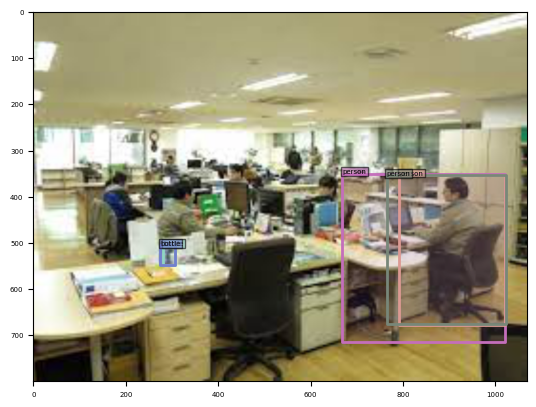

In [222]:
visualization(output_1)

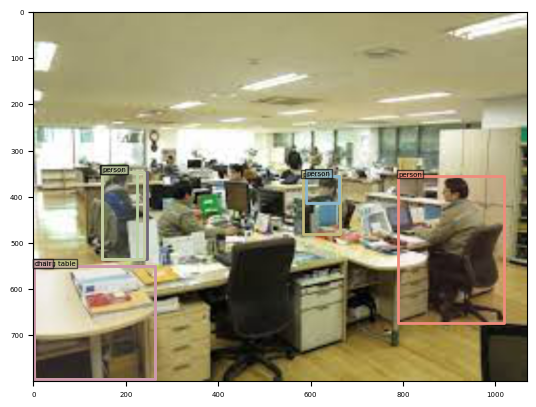

In [223]:
visualization(output_6)

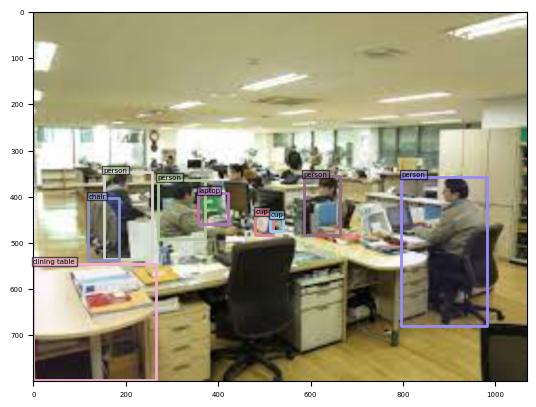

In [224]:
visualization(output_12)

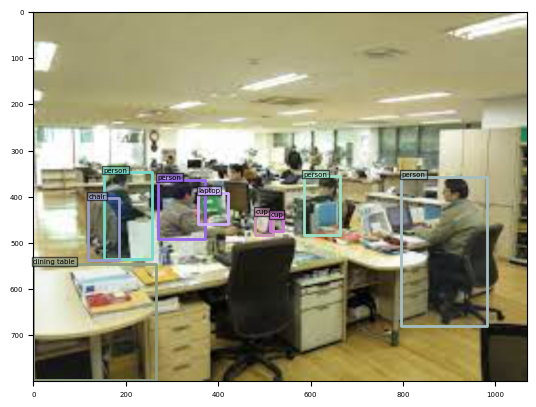

In [225]:
visualization(output_best)

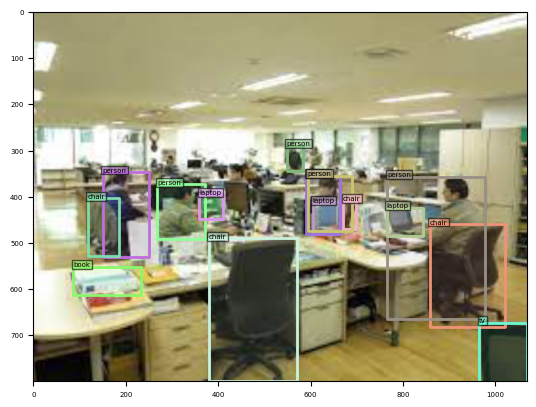

In [226]:
visualization(output)